## Libraries

In [ ]:
import os, sys, glob
import itertools
from datetime import datetime
import numpy as np
from joblib import Parallel, delayed
import io
import operator
import rasterio as rio
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import netCDF4



In [ ]:
import Global_Functions

import ee
ee.Authenticate(force=False)


## 1) Variable retrieval 

### 1.1) Fire data

In [ ]:
local_path = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA'
selection = pd.read_csv(f'{local_path}/Siberia/PeatFire/Datasets/Field_Data.csv')

<AxesSubplot:>

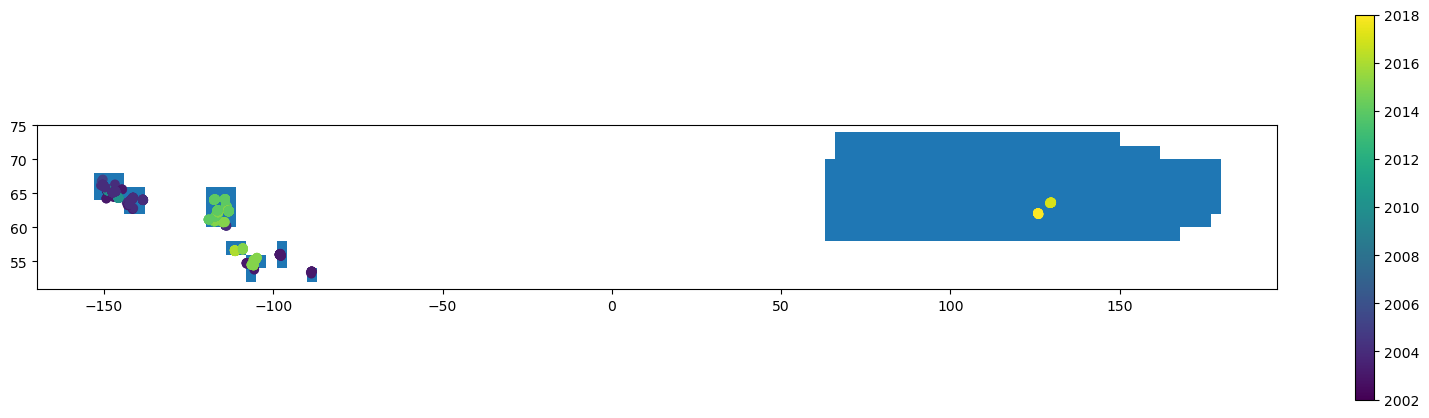

In [375]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
data_shp = gpd.GeoDataFrame(selection, 
    geometry=gpd.points_from_xy(selection.longitude, selection.latitude), crs="EPSG:4326")
Tiles_ABoVE = gpd.read_file(f'{local_path}/Regions/Tiles_ABoVE.shp')
Tiles_Siberia = gpd.read_file(f'{local_path}/Regions/Tiles_Siberia_3dLon.shp')
Tiles_shp =  gpd.GeoDataFrame(pd.concat([Tiles_ABoVE, Tiles_Siberia]))
drop_cols = ['year', 'PROJ', 'Samples', 'NBR']
Tiles_shp = Tiles_shp.drop(columns=drop_cols).drop_duplicates()
Tiles_shp.plot(ax=ax)
data_shp = data_shp.sjoin(Tiles_shp, how='left').drop(columns=['index_right'])
coord_list = [(x, y) for x, y in zip(data_shp["geometry"].x, data_shp["geometry"].y)]
data_shp[['zone', 'near_longitude', 'near_latitude', 'JD', 'patch_id', 'BA_patch', 'duration', 'BA_grid', 'Tmax', 'VPDmax', 'MCWD']] = None
data_shp.plot(ax=ax, column='burn_year', cmap='viridis', legend=True)

In [376]:
dataset, cutoff, gridres = 'Lndst', 16, 0.25
patch_cols = ['patch_id', 'BA_patch', 'duration']
LogFile = open(f'{local_path}/Siberia/PeatFire/Logs/Logfile_Fire_Data.txt', 'w')
# LogFile = io.StringIO()
Global_Functions.print_and_log(LogFile, f'{30 * "-"} LogFile of fire data assignment of field data {30 * "-"}\n\n')
i = 0
for p in data_shp.index[:]:
    coords = (data_shp.loc[p, "geometry"].x, 
                 data_shp.loc[p, "geometry"].y)
    tile = 'TILE-' + data_shp.loc[p, "TILE"]
    year = data_shp.loc[p, "burn_year"]
    zone = 'Siberia' if tile[-1] == 'E' else 'ABoVE'
    data_shp.loc[p, "zone"] = zone
    with rio.open(f'{local_path}/{zone}/PeatFire/ByTile/{tile}/Grid/BA_Area_{str(gridres).replace(".", "")}D_{tile}_{year}.tif') as src:
        data_shp.loc[p, "BA_grid"] = list(src.sample([coords]))[0][0]
    src_patch = rio.open(f"{local_path}/{zone}/ByTile/{tile}/Patches/TIF/BAMT_BA_{zone}_{dataset}_Patches-{cutoff}_{year}_{tile}.tif")
    label = list(src_patch.sample([coords]))[0][0]
    src_BA = rio.open(f'{local_path}/{zone}/ByTile/{tile}/Enhanced/Yearly/BAMT_BA_{zone}_{dataset}_{year}_{tile}_JD_Smooth_Dates.tif')
    ###### T eliminate later
    # src_BA2 = rio.open(f'{local_path}/{zone}/ByTile/{tile}/Enhanced2/Yearly/BAMT_BA_{zone}_{dataset}_{year}_{tile}_JD_Correct_Patches.tif')
    csv = pd.read_csv(f"{local_path}/{zone}/ByTile/{tile}/Patches/Tabular/BAMT_BA_{zone}_{dataset}_Patch-Stats-{cutoff}_{year}_{tile}.csv")
    JD = list(src_BA.sample([coords]))[0][0]
    if (label != 0) and (JD != 0):
        data_shp.loc[p, patch_cols] = csv.loc[csv.ID == f'{tile}_{label:05}', ['ID', 'AREA', 'DURATION']].values[0]
        data_shp.loc[p, "JD"] = list(src_BA.sample([coords]))[0][0]
            
    else:
        lat = int(tile[5:7])
        lon = int(tile[8:11])
        res = 0.00025
        max_dis = 500
        window = max_dis/30
        distance = Global_Functions.create_buffer(lon, lat-1, window/1000)[0] - lon
        k_lon = round(distance / res)
        x, y = coords
        x_coords = np.arange(x-(res*k_lon*window), x+res*(k_lon*window+1), res)
        y_coords = np.arange(y-(res*window), y+(res*window), res)
        all_coords = list(itertools.product(x_coords, y_coords))
        vals = np.array([i[0] for i in src_BA.sample(all_coords)])
        vals[vals < 0] = 0
        if vals.max() > 0:
            # print(p, data_shp.loc[p, "TILE"], vals.shape, vals)
            near_arr = np.abs(np.array(all_coords)-np.array([x, y]))/np.array([k_lon, 1])
            near_arr[vals == 0] = np.array([1, 1])
            nearest_idx = np.argmin(np.square(near_arr).sum(axis=1), axis=0) ## euclidean distance
            near = np.array(all_coords)[nearest_idx]
            data_shp.loc[p, "near_longitude"] = near[0]
            data_shp.loc[p, "near_latitude"] = near[1]
            data_shp.loc[p, "JD"] = vals[nearest_idx]
            label = list(src_patch.sample([near]))[0][0]
            data_shp.loc[p, patch_cols] = csv.loc[csv.ID == f'{tile}_{label:05}', ['ID', 'AREA', 'DURATION']].values[0]     
            Global_Functions.print_and_log(LogFile, '\t\t*** Index: %s, id: %s, tile: %s, year: %s is relocated to %s' 
              %(p, *data_shp.loc[p, ['plot_id', 'TILE', 'burn_year']].values, near)) 

        ###### Look for the nearest JD in 1km buffer, the coords aren't replaced 
        else:
            max_dis = 1000
            window = max_dis/30
            distance = Global_Functions.create_buffer(lon, lat-1, window/1000)[0] - lon
            k_lon = round(distance / res)
            x, y = coords
            x_coords = np.arange(x-(res*k_lon*window), x+res*(k_lon*window+1), res)
            y_coords = np.arange(y-(res*window), y+(res*window), res)
            all_coords = list(itertools.product(x_coords, y_coords))
            vals = np.array([i[0] for i in src_BA.sample(all_coords)])
            vals[vals < 0] = 0
            if vals.max() > 0:
                # print(vals)
                near_arr = np.abs(np.array(all_coords)-np.array([x, y]))/np.array([k_lon, 1])
                near_arr[vals == 0] = np.array([1, 1])
                nearest_idx = np.argmin(np.square(near_arr).sum(axis=1), axis=0) ## euclidean distance
                near = np.array(all_coords)[nearest_idx]
                data_shp.loc[p, "JD"] = vals[nearest_idx]
                label = list(src_patch.sample([near]))[0][0]
                data_shp.loc[p, patch_cols] = csv.loc[csv.ID == f'{tile}_{label:05}', ['ID', 'AREA', 'DURATION']].values[0]     
                Global_Functions.print_and_log(LogFile, '\t\t*** Index: %s, id: %s, tile: %s, year: %s is filled with the values of %s' 
                  %(p, *data_shp.loc[p, ['plot_id', 'TILE', 'burn_year']].values, near)) 
            else:
                i += 1
                Global_Functions.print_and_log(LogFile, '\t\t--- Index: %s, id: %s, tile: %s, year: %s has no near data' 
                  %(p, *data_shp.loc[p, ['plot_id', 'TILE', 'burn_year']].values))
 

------------------------------ LogFile of fire data assignment of field data ------------------------------


		*** Index: 0, id: AK_KT.sf.2, tile: 66N147W, year: 2003 is relocated to [-144.71321667   65.58598333]
		*** Index: 12, id: AK_KT.sf.15, tile: 66N147W, year: 2004 is relocated to [-146.72241667   65.34008333]
		*** Index: 20, id: AK_KT.sf.23, tile: 66N150W, year: 2004 is relocated to [-147.40971667   65.13993333]
		*** Index: 24, id: AK_KT.sf.27, tile: 66N147W, year: 2004 is relocated to [-146.78441667   65.33633333]
		--- Index: 25, id: AK_KT.sf.28, tile: 68N147W, year: 2004 has no near data
		--- Index: 32, id: AK_KT.sf.36, tile: 66N150W, year: 2004 has no near data
		*** Index: 33, id: AK_KT.sf.37, tile: 64N144W, year: 2004 is relocated to [-142.11626667   63.99938333]
		*** Index: 34, id: AK_KT.sf.38, tile: 64N144W, year: 2004 is relocated to [-142.11631667   63.99973333]
		--- Index: 36, id: AK_KT.sf.35, tile: 66N150W, year: 2003 has no near data
		*** Index: 43, id: AK_K

In [377]:
for i in data_shp.index:
    if not data_shp.loc[i, "near_longitude"]:
        data_shp.loc[i, "near_longitude"] = data_shp.loc[i, "longitude"]
        data_shp.loc[i, "near_latitude"] = data_shp.loc[i, "latitude"]
data_shp_filter = data_shp.loc[~np.isnan(np.asfarray(data_shp.JD))]

### 1.2) NBR, NBR2

In [7]:
def calculate_NBR(idx_df, year, jd, depth, bgcc, lon, lat, logfile=False):
    # print(idx_df, lon, lat, year, flush=True)
    if not logfile:
        logfile = io.StringIO()
        
    """----- Main functions ------"""
    def get_indices(image):
        nbr2 = image.normalizedDifference(['SWIR2', 'SWIR1']).multiply(10000).int16()
        nbr = image.normalizedDifference(['SWIR2', 'NIR']).multiply(10000).int16()
        return image.int16().addBands([nbr2.rename(['NBR2']), nbr.rename(['NBR'])])

    def mask_landsat(image):
        date = ee.Number.parse(ee.Date(image.get('system:time_start')).format('yyyyDDD'))
        mask = image.select('QA_PIXEL').bitwiseAnd(ee.Number(2).pow(3).int()).eq(0) \
            .And(image.select('QA_PIXEL').bitwiseAnd(ee.Number(2).pow(4).int()).eq(0)) \
            .And(image.select('QA_PIXEL').bitwiseAnd(ee.Number(2).pow(2).int()).eq(0)) \
            .And(image.select('QA_PIXEL').bitwiseAnd(ee.Number(2).pow(5).int()).eq(0))
        satellite = ee.String(image.get('SPACECRAFT_ID'))
        image = ee.Image(ee.Algorithms.If(
        satellite.compareTo('LANDSAT_4').eq(0) \
          .Or(satellite.compareTo('LANDSAT_5').eq(0)) \
          .Or(satellite.compareTo('LANDSAT_7').eq(0)),
        image.select(['SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']) \
          .multiply(0.0000275).add(-0.2).multiply(10000) \
          .rename(['Red', 'NIR', 'SWIR1', 'SWIR2']),
        image.select(['SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']) \
          .multiply(0.0000275).add(-0.2).multiply(10000) \
          .rename(['Red', 'NIR', 'SWIR1', 'SWIR2'])
        ))
        image = image.updateMask(mask.eq(1))
        image = image.updateMask(image.select('NIR').gt(50).And(image.select('Red').gt(50)))
            ## additional mask for clouds missed by CFMask, here NIR is more restrictive
        image = image.updateMask(image.select('SWIR2').lt(3000).And(image.select('NIR').lt(2600)))             
        return image

    """----- Processing ------"""
    point = ee.Geometry.Point([lon, lat])
    xmin, ymin = Global_Functions.create_buffer(lon, lat, -30/1000)
    xmax, ymax = Global_Functions.create_buffer(lon, lat, 30/1000)
    rect_buffer = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])
    date_1 = f'{int(year)-2}-03-01'
    date_2 = f'{int(year)-1}-12-01'
    date_2_2 = f'{int(year)}-03-01'
    date_3 = f'{int(year)+1}-12-01'

    pre_image = ee.ImageCollection('LANDSAT/LT04/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_1, date_2) \
        .merge(ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_1, date_2)) \
        .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_1, date_2)) \
        .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_1, date_2)) \
        .map(mask_landsat).map(get_indices)

    post_image = ee.ImageCollection('LANDSAT/LT04/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_2_2, date_3) \
        .merge(ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_2_2, date_3)) \
        .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_2_2, date_3)) \
        .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(rect_buffer).filterDate(date_2_2, date_3)) \
        .map(mask_landsat).map(get_indices)

    pre_image = pre_image.median()#.qualityMosaic('NBR')
    post_image = post_image.qualityMosaic('NBR')
    pre_values = pre_image.select(['NBR', 'NBR2']).reduceRegion(reducer=ee.Reducer.median(),
                            geometry=point, scale=30, crs='EPSG:4326').getInfo()
    post_values = post_image.select(['NBR', 'NBR2']).reduceRegion(reducer=ee.Reducer.max(),
                            geometry=point, scale=30, crs='EPSG:4326').getInfo()

    pre_nbr = np.array([-n / 10000 for n in pre_values.values()])
    post_nbr = np.array([-n / 10000 for n in post_values.values()])
    diff_nbr = post_nbr - pre_nbr

    if diff_nbr[0]>0:
        Global_Functions.print_and_log(logfile, f""" \t\t--- site {idx_df}: {lon}, {lat}, date: {year}{jd}, 
        depth: {depth}, BG_CC: {bgcc},  has a wrong NBR post/diff: {post_nbr[0], diff_nbr[0]}, {pre_values.values(), post_values.values()}""")  
        
    logs = {'year': year, 'text': logfile.getvalue()}
    results = dict(idx_df = idx_df,
                   post_NBR = post_nbr[0],
                   post_NBR2 = post_nbr[1],
                   diff_NBR = diff_nbr[0],
                   diff_NBR2 = diff_nbr[1])
    return dict(logs, **results)    

In [445]:
LogFile = open(f'{local_path}/Siberia/PeatFire/Logs/Logfile_NBR_retrieval.txt', 'w')
# LogFile = io.StringIO()
Global_Functions.print_and_log(LogFile, f'{30 * "-"} LogFile of NBR/2 assignment of field data {30 * "-"}\n\n')

cols = ['burn_year', 'JD', 'burn_depth', 'bg_c_combusted', 'near_longitude', 'near_latitude']
time0 = datetime.now()
list_gee_NBR = Parallel(n_jobs=22, verbose=100, backend='threading') (delayed(calculate_NBR) (
            i, *data_shp_filter.loc[i, cols]) for i in data_shp_filter.index)
list_gee_NBR.sort(key=operator.itemgetter('year'))
[LogFile.write(list_gee_NBR[i]['text']) for i in range(len(list_gee_NBR))]
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()

------------------------------ LogFile of NBR/2 assignment of field data ------------------------------


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=22)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=22)]: Done   3 tasks      | elapsed:    4.5s
[Parallel(n_jobs=22)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=22)]: Done   5 tasks      | elapsed:    4.5s
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    4.6s
[Parallel(n_jobs=22)]: Done   7 tasks      | elapsed:    4.6s
[Parallel(n_jobs=22)]: Done   8 tasks      | elapsed:    4.6s
[Parallel(n_jobs=22)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=22)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=22)]: Done  11 tasks      | elapsed:    4.7s
[Parallel(n_jobs=22)]: Done  12 tasks      | elapsed:    4.8s
[Parallel(n_jobs=22)]: Done  13 tasks      | elapsed:    4.8s
[Paral

In [446]:
layers = [i for i in list_gee_NBR[0]][3:]
data_shp_filter[layers] = None
for l in list_gee_NBR:
    for i in layers: 
        data_shp_filter.loc[l['idx_df'], i] = l[i]

### 1.3) Climate data 

In [ ]:
terraClimate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").map(lambda img: 
                       img.addBands([img.expression('b("aet") / b("pet")').rename('esi'), 
                                    img.expression('b("aet") - b("pet")').rename('det')]))
cems_ic = ee.ImageCollection('projects/climate-engine-pro/assets/ce-cems-fire-daily-4-1')
Tiles = ee.FeatureCollection("users/fireccihrba/BAMT/Regions/Tiles_ABoVE")

def get_lngTerm_stat(col, stat, months=[7, 8]):
    ## If you filter the year ypu will have a changing stats, not a worthed heavy processing
     # .filter(ee.Filter.calendarRange(int(year), int(year), 'year').Not()) 
    lngTerm = col.filter(ee.Filter.calendarRange(months[0], months[1], 'month')) \
        .map(lambda img: img.set('year', ee.Date(img.get('system:time_start')).get('year')))
    distYear = lngTerm.distinct('year')
    joinedCol = ee.Join.saveAll('sameYear').apply(distYear, lngTerm, 
                     ee.Filter.equals(**{'leftField': 'year', 'rightField': 'year'}))
    lngTerm_stat = ee.ImageCollection(joinedCol.map(lambda img: ee.ImageCollection.fromImages(img.get('sameYear')) \
                                .reduce(stat).set('year', img.get('year'))))
    return lngTerm_stat

def get_summer_stats(col, band, stat, date_start, date_end):
    subset = col.select(band).filterDate(date_start, date_end)
    result = subset.reduce(stat)
    lngTerm_stat = get_lngTerm_stat(col.select(band), stat, months=[7, 8])
    anomaly = result.subtract(lngTerm_stat.reduce(ee.Reducer.mean())).divide(lngTerm_stat.reduce(ee.Reducer.stdDev()))
    return result, anomaly

def get_cumulative_stats(col, band, stat, date_start, date_end):
    col = col.select(band)
    days_list = col.aggregate_array('system:index').getInfo()
    years_list = np.unique([i[:4] for i in days_list])
    years_list = ee.List(years_list.tolist())
    init_col = ee.ImageCollection([])
    def cumulative_stat(y, cum_col):
        # start = ee.Date(ee.Number.parse(y).format('%d-06-01'))
        # end = ee.Date(ee.Number.parse(y).format('%d-10-01'))
        start = ee.Date(date_start).update(year=ee.Number.parse(y))
        end = ee.Date(date_end).update(year=ee.Number.parse(y))
        image_stat = ee.ImageCollection(col).filterDate(start, end).reduce(stat).set('year', y)
        return ee.ImageCollection(cum_col).merge(image_stat)
    
    cumul_stat = ee.ImageCollection(years_list.iterate(cumulative_stat, init_col))
    result = cumul_stat.filter(ee.Filter.eq('year', date_start[:4])).first()
    anomaly = result.subtract(cumul_stat.reduce(ee.Reducer.mean())).divide(cumul_stat.reduce(ee.Reducer.stdDev()))   
    return result, anomaly
    
def get_terraclimate(idx_df, year, jd, lon, lat):
    print(idx_df, lon, lat, year, jd, flush=True)
    point = ee.Geometry.Point([lon, lat])
    date_start = f'{year}-07-01'
    date_end = f'{year}-09-01'
    
    """----- Main functions ------"""
    
    def get_yearly_mcwd(y, mcwd_lngterm):
        start = ee.Date(ee.Number(y).format('%d-01-01'))
        end = ee.Date(ee.Number(y).format('%d-09-01'))
        rain = terraClimate.select('pr').filterDate(start, end)
        evap = terraClimate.select('aet').filterDate(start, end).map(lambda image: image.multiply(0.1))
        acc_wd_rec = ee.ImageCollection([])
        
        def get_mcwd(aet, acc_wd):
            ide = aet.get('system:index')
            p = rain.filter(ee.Filter.eq('system:index', ide)).first()
            aet = evap.filter(ee.Filter.eq('system:index', ide)).first()
            water_deficit = aet.subtract(p).multiply(aet.gte(p))
            ## the same result as the following
            # water_deficit = aet.subtract(p).updateMask(aet.gte(p)).unmask(0)
            return ee.ImageCollection(acc_wd).merge(water_deficit)
        
        mcwd_rec = ee.ImageCollection(evap.iterate(get_mcwd, acc_wd_rec)).sum().rename('mcdw')
        mcwd_rec = mcwd_rec.set('system:time_start', start).set('system:time_end', end)
        return ee.ImageCollection(mcwd_lngterm).merge(mcwd_rec)
        
    def download_image(image, name):
        idx_list = data_shp_filter.loc[idx_df].idx_list
        ## each sin pixel correspnds to only 1 3x2 deg
        tilename = data_shp.query(f'index in {idx_list}').TILE.values[0]
        tile = Tiles.filter(ee.Filter.eq('TILE', tilename))
        export_folder = 'TerraClimate_PeatFire'
        proj = terraClimate.first().projection()
        task = ee.batch.Export.image.toDrive(image=image, 
                              description=f'{name}_{tilename}.tif', 
                              folder=export_folder, 
                              crs='EPSG:4326',  
                              crsTransform=proj.getInfo()['transform'], 
                              region=tile.geometry(), 
                              maxPixels=1e13)  
        task.start()
        

    """----- Processing ------"""
    acc_wd = ee.ImageCollection([])
    mcwd_lngterm = ee.ImageCollection(ee.List.sequence(1958, 2023, 1).iterate(get_yearly_mcwd, acc_wd))
    mcwd_image = mcwd_lngterm.filter(ee.Filter.calendarRange(int(year), int(year), 'year')).first()
    mcwd_anomaly = mcwd_image.subtract(mcwd_lngterm.mean()).divide(mcwd_lngterm.reduce(ee.Reducer.stdDev()))

    ## MEAN STATS
    terra_stats = get_cumulative_stats(terraClimate, 
           ['tmmx', 'tmmn', 'vpd', 'srad', 'pdsi', 'def', 'soil', 'pr', 'pet', 'aet', 'esi', 'det'], 
            ee.Reducer.mean(), date_start, date_end)
    layers = ['Tmax', 'Tmin', 'vpd', 'solar_down', 'pdsi', 'cwd', 'moisture', 'P', 'PET', 'AET', 'ESI', 'diffET']
    # print(terra_stats[0].bandNames().getInfo())
    anomaly_layers = [f'{l}_anomaly' for l in layers]
    monthly_means = terra_stats[0].rename(layers)
    monthly_anomalies = terra_stats[1].rename(anomaly_layers)

    ## Drought Code
    bands_cems = ['duff_moisture_code', 'fine_fuel_moisture_code', 'fire_weather_index']
    cems_mean, cems_mean_anomaly = get_cumulative_stats(cems_ic, 
            bands_cems, 
            ee.Reducer.mean(), date_start, date_end)
    layers_cems = ['duff_moisture', 'finefuel_moisture', 'FWI']
    anomaly_layers_cems = [f'{l}_anomaly' for l in layers_cems]
    monthly_cems_means = cems_mean.rename(layers_cems)
    monthly_cems_anomalies = cems_mean_anomaly.rename(anomaly_layers_cems)    

    snow_stats = get_cumulative_stats(terraClimate, ['swe'], 
            ee.Reducer.mean(), f'{year}-03-01', f'{year}-06-01')
    
    proj = terraClimate.first().projection()
    mcwd = mcwd_image.reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=proj.getInfo()['transform']).getInfo()
    mcwd_anomaly = mcwd_anomaly.reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=proj.getInfo()['transform']).getInfo() 
    monthly_means = monthly_means.reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=proj.getInfo()['transform']).getInfo()
    monthly_anomalies = monthly_anomalies.reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=proj.getInfo()['transform']).getInfo()
    monthly_cems_means = monthly_cems_means.reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=cems_ic.first().projection().getInfo()['transform']).getInfo()
    monthly_cems_anomalies = monthly_cems_anomalies.reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=cems_ic.first().projection().getInfo()['transform']).getInfo()
    snow_mean = snow_stats[0].rename('SWE').reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=proj.getInfo()['transform']).getInfo()
    snow_anomaly = snow_stats[1].rename('SWE_anomaly').reduceRegion(ee.Reducer.mean(), point, 
               crsTransform=proj.getInfo()['transform']).getInfo()
    # print(monthly_means)
    results= {}
    results = dict(idx_df = idx_df,
                   MCWD_terra = mcwd['mcdw'],
                   MCWD_anomaly = mcwd_anomaly['mcdw'],
                   Tmax_terra = monthly_means[layers[0]] * 0.1, # deg C
                   Tmax_anomaly = monthly_anomalies[anomaly_layers[0]],
                   Tmin_terra = monthly_means[layers[1]] * 0.1, 
                   Tmin_anomaly = monthly_anomalies[anomaly_layers[1]], 
                   VPD_terra = monthly_means[layers[2]] * 0.01, # deg kPa
                   VPD_anomaly = monthly_anomalies[anomaly_layers[2]],
                   solar_down_terra = monthly_means[layers[3]] * 0.1,  # W/m^2
                   solar_down_anomaly = monthly_anomalies[anomaly_layers[3]],  
                   pdsi = monthly_means[layers[4]] * 0.01, # unitless
                   pdsi_anomaly = monthly_anomalies[anomaly_layers[4]], 
                   cwd = monthly_means[layers[5]] * 0.1, # mm
                   cwd_anomaly = monthly_anomalies[anomaly_layers[5]],  
                   # snow = monthly_means[layers[6]], # mm
                   # snow_anomaly = monthly_anomalies[anomaly_layers[6]], 
                   moisture_terra = monthly_means[layers[6]] * 0.1, # mm
                   moisture_anomaly = monthly_anomalies[anomaly_layers[6]] 
                  )
    
    results.update({'SWE': snow_mean['SWE'], 'SWE_anomaly': snow_anomaly['SWE_anomaly']})
    added_terra = dict([(l, monthly_means[l]) for l in layers[-5:]])
    added_terra.update([(l, monthly_anomalies[l]) for l in anomaly_layers[-5:]])
    results.update(**results, 
                   **added_terra,
                   **monthly_cems_means,
                   **monthly_cems_anomalies
                  )
    
    return results

In [45]:
cols = ['burn_year', 'JD', 'near_longitude', 'near_latitude']
list_gee_terra = Parallel(n_jobs=40, verbose=100, backend='threading') (delayed(get_terraclimate) (
            i, *data_shp_filter.loc[i, cols]) for i in data_shp_filter.index)

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
0 -144.71321666666674 65.58598333333323 2003 168
1 -144.5912 65.6029 2004 222
2 -145.2483 65.525 2004 237
3 -144.6651 65.5918 2004 223
4 -141.5316 62.6914 2003 221
5 -147.432 65.1203 2004 183
6 -147.4276 65.1164 2004 183
7 -147.4286 65.1182 2004 183
8 -147.4317 65.1225 2004 183
9 -147.4329 65.1236 2004 183
10 -146.1903 65.3529 2004 195
11 -146.7849 65.3345 2004 179
12 -146.7224166666667 65.34008333333324 2004 176
13 -146.7006 65.3392 2004 179
14 -146.6686 65.3465 2004 179
15 -146.6804 65.3435 2004 179
16 -147.4247 65.1163 2004 183
17 -147.4258 65.1197 2004 183
18 -147.1317 65.2208 2004 182
19 -147.1313 65.2337 2004 182
20 -147.40971666666675 65.13993333333327 2004 183
21 -147.4128 65.1432 2004 183
22 -146.6712 65.351 2004 179
23 -146.7543 65.3358 2004 178
24 -146.78441666666677 65.33633333333326 2004 179
26 -146.7114 65.3303 2004 176
27 -146.7333 65.3413 2004 178
28 -142.45 63.4772 2004 176
29 -147.4724 6

In [46]:
layers = [i for i in list_gee_terra[0]][1:]
data_shp_filter[layers] = None
for l in list_gee_terra:
    # print(l['idx_df'])
    for i in layers: 
        data_shp_filter.loc[l['idx_df'], i] = l[i]
data_shp_filter

,plot_id,project_name,treatment,burn_year,latitude,longitude,ag_c_prefire,ag_c_combusted,prefire_sol,burn_depth,...,PET_anomaly,AET_anomaly,ESI,diffET,ESI_anomaly,diffET_anomaly,DC_anomaly,SWE,SWE_anomaly,AGB
0,AK_KT.sf.2,AK_KT,burn,2003,65.58540,-144.71280,-9999.00,-9999.00,27.0,13.7,...,-0.29094,0.202545,0.495451,-457.5,0.139813,0.262239,-0.398961,17.333333,-1.298072,13
1,AK_KT.sf.4,AK_KT,burn,2004,65.60290,-144.59120,-9999.00,-9999.00,22.0,5.2,...,1.935367,-1.98224,0.147962,-864,-2.097857,-2.238986,2.254730,19.333333,-1.087281,36
2,AK_KT.sf.5,AK_KT,burn,2004,65.52500,-145.24830,-9999.00,-9999.00,25.5,16.0,...,1.934181,-1.91102,0.191755,-779,-2.059471,-2.162944,2.008069,20.333333,-0.558124,50
3,AK_KT.sf.6,AK_KT,burn,2004,65.59180,-144.66510,-9999.00,-9999.00,21.7,21.7,...,1.935287,-1.964614,0.150502,-863.5,-2.085398,-2.223069,2.182107,19,-1.114116,6
4,AK_KT.sf.3,AK_KT,burn,2003,62.69140,-141.53160,-9999.00,-9999.00,18.4,14.0,...,1.26302,-0.603625,0.59828,-380,-0.817965,-0.889225,-0.047029,40.666667,-0.872917,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,YE012B,SIB_Yert,burn,2018,62.08051,125.91018,3245.16,683.60,15.4,8.6,...,-0.290944,0.745519,0.654191,-342.5,0.54476,0.623992,0.882978,55,-0.330112,52
899,YE015B,SIB_Yert,burn,2018,61.95696,126.03944,2484.64,814.55,14.6,12.2,...,-0.288525,0.668619,0.646344,-353,0.499964,0.571268,0.882978,53.333333,-0.377797,28
900,YE019B,SIB_Yert,burn,2018,61.96376,126.00948,2154.68,271.51,11.7,9.9,...,-0.312583,0.696855,0.655893,-340.5,0.523832,0.599845,0.882978,53,-0.356094,30
901,YE021B,SIB_Yert,burn,2018,61.96060,126.01952,6477.50,1942.87,14.0,10.5,...,-0.312583,0.696855,0.655893,-340.5,0.523832,0.599845,0.882978,53,-0.356094,51


### 1.4) SoilGrids data

In [ ]:
clay_image = ee.Image('projects/soilgrids-isric/clay_mean')
sand_image = ee.Image('projects/soilgrids-isric/sand_mean')
silt_image = ee.Image('projects/soilgrids-isric/silt_mean')
bd_image = ee.Image('projects/soilgrids-isric/bdod_mean')


def get_soilgrids(idx_df, lon, lat, logfile=False):
    if not logfile:
        logfile = io.StringIO()
    
    results = dict(idx_df = idx_df)
    point = ee.Geometry.Point([lon, lat])
    layers = ['sand', 'silt', 'clay', 'bdod', 'soc']
    """ The coefficients should ideally be [0-5]: 1/6, [5-15]: 1/3, [15-30]: 1/2 
        However, since the fire attacks the top layers first we use 1/3 for all"""
    coef = [1/3, 1/3, 1/3]
    bands = ['0-5cm_mean', '5-15cm_mean', '15-30cm_mean']
    for l in layers:
        image = ee.Image(f'projects/soilgrids-isric/{l}_mean').select([f'{l}_{b}' for b in bands])
        profile_values = image.reduceRegion(ee.Reducer.median(), point, scale=250).getInfo()
        # print(profile_values)
        if profile_values[f'{l}_0-5cm_mean'] == None:
            buf = 250
            # if not profile_values[f'{l}_0-5cm_mean']:
            buf = 250
            while profile_values[f'{l}_0-5cm_mean'] == None:
                buffer = point.buffer(buf)
                profile_values = image.reduceRegion(ee.Reducer.median(), buffer, scale=250).getInfo()
                buf += 250
                
            Global_Functions.print_and_log(logfile, f'\t\t*** Index {idx_df}, lon/lat {lon}, {lat}: is falling in water buffered to {buf}') 
        results[l] = np.array([i*c for i, c in zip(profile_values.values(), coef)]).sum()
    logs = {'idx_df': idx_df, 'text': logfile.getvalue()}
    return dict(logs, **results)

In [117]:
# LogFile = open(f'{local_path}/Siberia/PeatFire/Logs/Logfile_SoiGrids.txt', 'w')
LogFile = io.StringIO()
Global_Functions.print_and_log(LogFile, f'{30 * "-"} LogFile of SoilGrids assignment of field data {30 * "-"}\n\n')

cols = ['near_longitude', 'near_latitude']
# for i in data_shp_filter.index[350:]:
#     get_soilgrids(i, *data_shp_filter.loc[i, cols])
time0 = datetime.now()
gee_soil = Parallel(n_jobs=22, verbose=100, backend='threading') (delayed(get_soilgrids) (
            i, *data_shp_filter.loc[i, cols]) for i in data_shp_filter.index)
gee_soil.sort(key=operator.itemgetter('idx_df'))
[LogFile.write(gee_soil[i]['text']) for i in range(len(gee_soil))]
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()

------------------------------ LogFile of SoilGrids assignment of field data ------------------------------


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=22)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=22)]: Done   3 tasks      | elapsed:    2.0s
[Parallel(n_jobs=22)]: Done   4 tasks      | elapsed:    2.0s
[Parallel(n_jobs=22)]: Done   5 tasks      | elapsed:    2.0s
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    2.0s
[Parallel(n_jobs=22)]: Done   7 tasks      | elapsed:    2.1s
[Parallel(n_jobs=22)]: Done   8 tasks      | elapsed:    2.1s
[Parallel(n_jobs=22)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=22)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=22)]: Done  11 tasks      | elapsed:    2.5s
[Parallel(n_jobs=22)]: Done  12 tasks      | elapsed:    2.5s
[Parallel(n_jobs=22)]: Done  13 tasks      | elapsed:    2.5s
[P

In [118]:
layers = ['sand', 'silt', 'clay', 'bdod', 'soc']
data_shp_filter[layers] = None
for l in gee_soil:
    for j in layers:
        data_shp_filter.loc[l['idx_df'], j] = l[j]

In [ ]:
data_shp_filter = pd.read_csv(f'{local_path}/Siberia/PeatFire/BG_CC/data/Data_All_Final.csv', index_col='Unnamed: 0')
data_shp_filter

,plot_id,project_name,treatment,burn_year,latitude,longitude,ag_c_prefire,ag_c_combusted,prefire_sol,burn_depth,...,diffET,ESI_anomaly,diffET_anomaly,DC_anomaly,SWE,SWE_anomaly,AGB,pred_agcc,pred_depth,pred_bgc
0,BR_SK1.sf.35,SK_RTJ,burn,2015,54.4419,-105.8067,4912.303,1719.306,5.5,0.0,...,-307.75,0.143957,-0.133998,0.600586,48.666667,-0.510249,136,1367.092931,9.498026,3651.447910
1,BR_SK1.sf.45,SK_RTJ,burn,2015,54.4038,-105.8166,5630.451,2252.180,4.6,0.0,...,-307.75,0.156968,-0.121112,0.600586,48.666667,-0.480314,137,935.755314,8.467768,3011.933091
2,BR_SK1.sf.65,SK_RTJ,burn,2015,55.2367,-105.2883,2586.734,1293.367,5.6,0.0,...,-334.75,-0.086554,-0.362016,1.119471,59.666667,-0.425661,89,951.675135,11.371709,3363.421106
3,BR_SK1.sf.75,SK_RTJ,burn,2015,56.9643,-108.9994,1864.573,794.981,3.7,0.7,...,-359.50,-0.655733,-0.829036,1.693261,67.666667,-0.184694,43,451.867221,5.448076,2822.660645
4,BR_SK1.sf.73,SK_RTJ,burn,2015,56.7943,-108.9552,714.840,234.666,21.1,0.7,...,-370.75,-0.727910,-0.938878,1.661114,60.000000,-0.323793,37,374.239436,5.385658,1708.030364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,AK_KT.sf.149,AK_KT,burn,2004,64.8839,-146.3044,-9999.000,-9999.000,32.6,31.4,...,-640.50,-1.752176,-2.514991,1.614745,34.333333,-0.694862,36,NaN,26.950504,6761.248721
892,AK_KT.sf.158,AK_KT,burn,2004,64.8873,-146.3107,-9999.000,-9999.000,33.9,32.2,...,-640.50,-1.752176,-2.514991,1.614745,34.333333,-0.694862,73,NaN,26.192990,7051.375654
893,AK_KT.sf.156,AK_KT,burn,2004,64.8876,-146.3131,-9999.000,-9999.000,34.6,33.0,...,-640.50,-1.752176,-2.514991,1.614745,34.333333,-0.694862,112,NaN,22.497799,5446.412729
894,AK_KT.sf.160,AK_KT,burn,2004,64.8833,-146.3042,-9999.000,-9999.000,34.3,33.4,...,-640.50,-1.752176,-2.514991,1.614745,34.333333,-0.694862,50,NaN,26.330330,6423.989153


### 1.5) LST anomaly
#### Terra 10:30pm pass time: complete timeseries
#### Aqua 01:30am pass time: 2003 onwards 

In [ ]:
Tiles_MODIS_gee = ee.FeatureCollection("users/fireccihrba/BAMT/Regions/MODIS_GRID_WGS84")

def get_summer_stats(col, band, stat, date_start, date_end):
    subset = col.select(band).filterDate(date_start, date_end)
    result = subset.reduce(stat)
    lngTerm_stat = get_lngTerm_stat(col.select(band), stat, months=[7, 8])
    anomaly = result.subtract(lngTerm_stat.reduce(ee.Reducer.mean())).divide(lngTerm_stat.reduce(ee.Reducer.stdDev()))
    return result, anomaly

def LST_anomaly(idx_df, year, jd, lon, lat, satellite='Terra', scale=1000, logfile=False):
    if not logfile:
        logfile = io.StringIO()
    point = ee.Geometry.Point([lon, lat])
    date_start = f'{year}-07-01'
    date_end = f'{year}-09-01'  
    stat = ee.Reducer.mean()
    if satellite == 'Aqua':
        ## 
        modis_11 = ee.ImageCollection("MODIS/061/MYD11A2")
    elif satellite == 'Terra':
        ## pass time 10:30 pm, most 
        modis_11 = ee.ImageCollection("MODIS/061/MOD11A2")
        
    modis_11 = modis_11.select('LST_Night_1km')
    days_list = modis_11.aggregate_array('system:index')
    ini = ee.List([])
    years_list = ee.List(days_list).map(lambda x: ee.String(x).slice(0, 4)).distinct()
    init_col = ee.ImageCollection([])
    def cumulative_stat(y, cum_col):
        start = ee.Date(ee.Number.parse(y).format('%d-07-01'))
        end = ee.Date(ee.Number.parse(y).format('%d-09-01'))
        single_year = ee.ImageCollection(modis_11).filterDate(start, end).toBands()
        doys = single_year.bandNames().map(lambda x: 
                   ee.Number.parse(ee.Date.parse('yyyy_MM_dd', ee.String(x).slice(0, 10)).format('D')))
        periods = doys.map(lambda x: ee.Number(x).divide(8).int())
        ini = ee.List([])
        names = periods.iterate(lambda x, ini: 
                   ee.List(ini).add(ee.String('image_').cat(ee.Number(x).format('%d'))), ini)
        
        single_year = single_year.rename(names)
        stat_image = single_year.reduce(stat).rename('stat_image')
        single_year = single_year.addBands(stat_image).set('year', y)
        return ee.ImageCollection(cum_col).merge(single_year)
        
    cumul_stat = ee.ImageCollection(years_list.iterate(cumulative_stat, init_col))
    overall_stat = cumul_stat.select('.*stat_image')
    LST_mean = overall_stat.filter(ee.Filter.eq('year', ee.String(date_start).slice(0, 4))).first()
    anomaly = LST_mean.subtract(overall_stat.reduce(ee.Reducer.mean())).divide(overall_stat.reduce(ee.Reducer.stdDev())) 
    year_image = cumul_stat.filter(ee.Filter.eq('year', ee.String(date_start).slice(0, 4))).first()
    periods = year_image.select('[^.*stat].*').bandNames()
    init_col = ee.ImageCollection([])
    def get_period_anomaly(p, col):
        p = ee.String(p)
        subset = cumul_stat.select(p)
        subset_year = year_image.select(p)
        result = subset_year.subtract(subset.reduce(ee.Reducer.mean())).divide(subset.reduce(ee.Reducer.stdDev())) 
        result = result.where(result.gte(0.5), 1)
        result = result.where(result.lt(0.5), 0).rename('anomaly')
        return ee.ImageCollection(col).merge(result)
    
    period_anomaly = ee.ImageCollection(periods.iterate(get_period_anomaly, init_col)) 
    prop = period_anomaly.reduce(ee.Reducer.sum()).divide(period_anomaly.reduce(ee.Reducer.count()))
    
    if scale == 500:
        scale = 463.3127165693844
    elif scale == 1000:
        scale = 926.6254331387704
    elif scale == 250:
        scale = 231.6563582846922
    
    ## Use the proper scale otherwise you might end up having slight misgeolocation
    LST_stat = LST_mean.rename('mean_LST').reduceRegion(ee.Reducer.first(), point, scale=scale).getInfo()
    LST_anomaly = anomaly.rename('std_anomaly').reduceRegion(ee.Reducer.first(), point, scale=scale).getInfo()
    # print(cumul_stat.select('image_20').getInfo())
    LST_persistence = prop.rename('LST_persistence').reduceRegion(ee.Reducer.first(), point, scale=scale).getInfo()

    scale = 0.02    ## the processing with preprocess LST is almost 2 min and less than 20 sec without
    results = dict(idx_df = idx_df,
                   LST = LST_stat['mean_LST']*scale,
                   LST_anomaly_std = LST_anomaly['std_anomaly'],
                   LST_persistence = LST_persistence['LST_persistence'], 
                  )
    logs = {'idx_df': idx_df, 'text': logfile.getvalue()}
    return dict(logs, **results)

#### Terra

In [81]:
sensor = 'Terra'
LogFile = open(f'{local_path}/Siberia/PeatFire/Logs/Logfile_LST_Anomaly_{sensor}.txt', 'w')
# LogFile = io.StringIO()
Global_Functions.print_and_log(LogFile, f'{30 * "-"} LogFile of LST anomaly assignment of field data {30 * "-"}\n\n')

cols = ['burn_year', 'JD', 'near_longitude', 'near_latitude']
time0 = datetime.now()
list_LST = Parallel(n_jobs=50, verbose=100, backend='threading') (delayed(LST_anomaly) (
            i, *data_shp_filter.loc[i, cols], sensor) for i in data_shp_filter.index[:])
list_LST.sort(key=operator.itemgetter('idx_df'))
[LogFile.write(list_LST[i]['text']) for i in range(len(list_LST))]
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()

------------------------------ LogFile of LST anomaly assignment of field data ------------------------------


[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=50)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=50)]: Done   3 tasks      | elapsed:    3.9s
[Parallel(n_jobs=50)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=50)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=50)]: Done   6 tasks      | elapsed:    4.1s
[Parallel(n_jobs=50)]: Done   7 tasks      | elapsed:    4.1s
[Parallel(n_jobs=50)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=50)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=50)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=50)]: Done  11 tasks      | elapsed:    4.3s
[Parallel(n_jobs=50)]: Done  12 tasks      | elapsed:    4.3s
[Parallel(n_jobs=50)]: Done  13 tasks      | elapsed:    4.3s


In [83]:
layers = [i for i in list_LST[0]][2:]
data_shp_filter[layers] = None
for l in list_LST:
    # print(l['idx_df'])
    for j in layers[:]:
        data_shp_filter.loc[l['idx_df'], j] = l[j]

### 1.6) FRP & peat information from Hugelius

In [429]:
dataset, cutoff = 'Lndst', 16
names = ['Histel_fraction', 'Histel_SOC_hg_per_sqm', 'Histosol_SOC_hg_per_sqm', 
         'Histel_ombrotrophic', 'Histosol_ombrotrophic', 
         'Histel_minerotrophic', 'Histosol_minerotrophic',
         'Mean_potential_peat_depth_cm']
cols = ['permafrost', 'permafrost_SOC', 'nonpermafrost_SOC', 
        'permafrost_bog','nonpermafrost_bog', 
        'permafrost_fen','nonpermafrost_fen', 'peat_depth']

data_shp_filter[cols] = None
for p in data_shp_filter.index[:]:
    coords = (data_shp_filter.loc[p, "near_longitude"], 
                 data_shp_filter.loc[p, "near_latitude"])
    tile = 'TILE-' + data_shp_filter.loc[p, "TILE"]
    year = data_shp_filter.loc[p, "burn_year"]
    zone = data_shp_filter.loc[p, "zone"]
    print(p, tile, year)
    
    with rio.open(f'{local_path}/{zone}/ByTile/{tile}/Voronoi/FRP/Hotspots_FRP_{year}_{tile}.tif') as src:
        data_shp_filter.loc[p, "FRP"] = list(src.sample([coords]))[0][0]

    for n, c in zip(names, cols):
        pathname = f'{local_path}/Ancillary/Higelius_Peat_properties/{n}_WGS84.nc'
        # print(pathname, n)
        filehandle = netCDF4.Dataset(pathname,'r',format="NETCDF4")
        lathandle = filehandle.variables['lat'][:]
        lonhandle = filehandle.variables['lon'][:]
        values = filehandle.variables[f'{n}_WGS84.tif'][:]
        values.mask = False
        values[values==values.fill_value] = 0
        lats=lathandle[:]
        lons=lonhandle[:]
        lat_index = np.argwhere(np.abs(lats-coords[1]) == np.abs(lats-coords[1]).min())[0, 0]
        lon_index = np.argwhere(np.abs(lons-coords[0]) == np.abs(lons-coords[0]).min())[0, 0]
        data_shp_filter.loc[p, c] = values[lat_index, lon_index]
        
    
data_shp_filter['SOC'] = data_shp_filter['permafrost_SOC'] + data_shp_filter['nonpermafrost_SOC']
data_shp_filter['bog'] = data_shp_filter['permafrost_bog'] + data_shp_filter['nonpermafrost_bog']
data_shp_filter['fen'] = data_shp_filter['permafrost_fen'] + data_shp_filter['nonpermafrost_fen']
data_shp_filter


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0 TILE-66N147W 2003
1 TILE-66N147W 2004
2 TILE-66N147W 2004
3 TILE-66N147W 2004
4 TILE-64N144W 2003
5 TILE-66N150W 2004
6 TILE-66N150W 2004
7 TILE-66N150W 2004
8 TILE-66N150W 2004
9 TILE-66N150W 2004
10 TILE-66N147W 2004
11 TILE-66N147W 2004
12 TILE-66N147W 2004
13 TILE-66N147W 2004
14 TILE-66N147W 2004
15 TILE-66N147W 2004
16 TILE-66N150W 2004
17 TILE-66N150W 2004
18 TILE-66N150W 2004
19 TILE-66N150W 2004
20 TILE-66N150W 2004
21 TILE-66N150W 2004
22 TILE-66N147W 2004
23 TILE-66N147W 2004
24 TILE-66N147W 2004
26 TILE-66N147W 2004
27 TILE-66N147W 2004
28 TILE-64N144W 2004
29 TILE-66N150W 2004
30 TILE-66N150W 2004
31 TILE-66N147W 2004
33 TILE-64N144W 2004
34 TILE-64N144W 2004
35 TILE-68N153W 2005
37 TILE-66N147W 2003
38 TILE-68N153W 2004
39 TILE-68N153W 2004
40 TILE-68N153W 2004
41 TILE-68N153W 2004
42 TILE-68N153W 2004
43 TILE-68N153W 2004
44 TILE-68N153W 2004
46 TILE-68N153W 2004
47 TILE-68N153W 2004
48 TILE-68N153W 2004
49 TILE-68N153W 2004
50 TILE-66N150W 2003
51 TILE-66N150W 2003
52

,plot_id,project_name,treatment,burn_year,latitude,longitude,ag_c_prefire,ag_c_combusted,prefire_sol,burn_depth,...,nonpermafrost_SOC,permafrost_bog,nonpermafrost_bog,permafrost_fen,nonpermafrost_fen,peat_depth,FRP,SOC,bog,fen
0,AK_KT.sf.2,AK_KT,burn,2003,65.58540,-144.71280,-9999.00,-9999.00,27.0,13.7,...,2,4,0,1,0,119,25.000000,43,4,1
1,AK_KT.sf.4,AK_KT,burn,2004,65.60290,-144.59120,-9999.00,-9999.00,22.0,5.2,...,4,5,0,0,0,126,19.600000,42,5,0
2,AK_KT.sf.5,AK_KT,burn,2004,65.52500,-145.24830,-9999.00,-9999.00,25.5,16.0,...,3,2,0,0,0,102,10.341881,21,2,0
3,AK_KT.sf.6,AK_KT,burn,2004,65.59180,-144.66510,-9999.00,-9999.00,21.7,21.7,...,5,11,0,2,0,120,15.664335,99,11,2
4,AK_KT.sf.3,AK_KT,burn,2003,62.69140,-141.53160,-9999.00,-9999.00,18.4,14.0,...,5,3,0,0,0,200,12.300000,54,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,YE012B,SIB_Yert,burn,2018,62.08051,125.91018,3245.16,683.60,15.4,8.6,...,1,1,0,0,0,305,26.702658,33,1,0
899,YE015B,SIB_Yert,burn,2018,61.95696,126.03944,2484.64,814.55,14.6,12.2,...,4,2,0,0,0,302,242.659576,46,2,0
900,YE019B,SIB_Yert,burn,2018,61.96376,126.00948,2154.68,271.51,11.7,9.9,...,4,2,0,0,0,302,15.789474,46,2,0
901,YE021B,SIB_Yert,burn,2018,61.96060,126.01952,6477.50,1942.87,14.0,10.5,...,4,2,0,0,0,302,15.789474,46,2,0


### 1.7) Topography

In [ ]:
def get_near_wgs(lons, lats, lon0, lat0, coef=1, return_rank=False):
    uniqueLons, countLons = np.unique(lons, return_counts=True)
    uniqueLats = np.unique(lats)
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
    if countLons[0] == 1:
        coords = np.column_stack([np.tile(lons, nrows), np.repeat(lats, ncols)])
    else:
        coords = np.column_stack([lons, lats])
    distance_2d = abs(coords - [lon0, lat0]) * [nrows/ncols*coef, coef]
    distance = np.sqrt(np.square(distance_2d).sum(axis=1)) ## euclidean distance
    if return_rank:
        near_idx = np.argsort(distance)
    else:
        near_idx = np.argmin(distance)
    near_coords = coords[near_idx]
    return near_idx, near_coords, distance[near_idx]

def get_topo(idx_df, year, jd, tile, lon, lat, logfile=False):
    if not logfile:
        logfile = io.StringIO()
    
    """----- Main functions ------"""    
    def LatLonImg(img):
        # bands = img.bandNames()
        img = img.addBands(ee.Image.pixelLonLat())
        data = img.reduceRegion(reducer=ee.Reducer.toList(),
                                            geometry=area,
                                            maxPixels=1e13,
                                            scale=30,
                                            tileScale=0.1).getInfo()
        lats = np.array(data["latitude"])
        lons = np.array(data["longitude"])
        return lats, lons, data 

    
                                           
    """----- Processing ------"""
    
    point = ee.Geometry.Point([lon, lat], 'EPSG:4326')
    area = point.buffer(100).bounds()
    dataset = ee.ImageCollection('JAXA/ALOS/AW3D30/V3_2')
    elevation = dataset.select('DSM')
    proj = elevation.first().select(0).projection()
    elevation_gee = elevation.mosaic().setDefaultProjection(proj).rename('elevation')
    elevation_gee = elevation_gee.addBands(ee.Image.pixelLonLat())
    slope_gee = ee.Terrain.slope(elevation_gee)
    aspect_gee = ee.Terrain.aspect(elevation_gee).convolve(ee.Kernel.square(1, 'pixels'))
    topo = elevation_gee.addBands(slope_gee).addBands(aspect_gee)
    results = topo.reduceRegion(reducer=ee.Reducer.first(),
                                        geometry=point,
                                        scale=30).getInfo()

    logs = {'idx_df': idx_df, 'text': logfile.getvalue()}
    return dict(logs, **results)

In [7]:
LogFile = open(f'{local_path}/Siberia/PeatFire/Logs/Logfile_Topography.txt', 'w')
# LogFile = io.StringIO()
Global_Functions.print_and_log(LogFile, f'{30 * "-"} LogFile of Topography assignment of field data {30 * "-"}\n\n')

cols = ['burn_year', 'JD', 'TILE', 'near_longitude', 'near_latitude']
time0 = datetime.now()
list_topo = Parallel(n_jobs=22, verbose=100, backend='threading') (delayed(get_topo) (
            i, *data_shp_filter.loc[i, cols]) for i in data_shp_filter.index[:])

list_topo.sort(key=operator.itemgetter('idx_df'))
[LogFile.write(list_topo[i]['text']) for i in range(len(list_topo))]
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()

------------------------------ LogFile of Topography assignment of field data ------------------------------


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=22)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=22)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=22)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.9s
[Parallel(n_jobs=22)]: Done   7 tasks      | elapsed:    1.0s
[Parallel(n_jobs=22)]: Done   8 tasks      | elapsed:    1.0s
[Parallel(n_jobs=22)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=22)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=22)]: Done  11 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done  13 tasks      | elapsed:    1.2s
[

In [8]:
layers = ['elevation', 'aspect', 'slope']#, 'TWI']
data_shp_filter[layers] = None
for i, l in enumerate(list_topo):
    for j in layers[:]:
        data_shp_filter.loc[l['idx_df'], j] = l[j]


### 1.8) Tree and non tree vegetation cover

In [ ]:
def get_VCF(idx_df, year, jd, tile, lon, lat, logfile=False):
    if not logfile:
        logfile = io.StringIO()
    point = ee.Geometry.Point([lon, lat], 'EPSG:4326')
    vcf = ee.ImageCollection("MODIS/006/MOD44B") \
          .filter(ee.Filter.date(f'{year}-01-01', f'{year+1}-01-01'))
    vcf = vcf.first().select(['Percent_Tree_Cover', 'Percent_NonTree_Vegetation']) \
                  .rename(['tree_cover', 'nontree_cover'])
    proj = vcf.projection()   
    results = vcf.reduceRegion(ee.Reducer.first(), point, scale=250).getInfo()
    
    if not results['tree_cover']:
        point = point.transform(proj)
        """ For some reason point.coordinates().getInfo() gives incorrect coords """
        x, y = point.getInfo()['coordinates']
        buf = 500
        c = list(itertools.product([x-buf, x+buf], [y-buf, y+buf]))
        c = [list(c[i]) for i in [1, 0, 2, 3]]
        area = ee.Geometry({'geodesic': False, 
                            'crs': {'type': 'name', 'properties': {'name': proj.crs().getInfo()}}, 
                            'type': 'Polygon', 'coordinates': [c]})
        vcf = vcf.addBands(ee.Image.pixelCoordinates(proj.crs().getInfo()).updateMask(vcf.select('tree_cover')))
        data = vcf.reduceRegion(reducer=ee.Reducer.toList(),
                                            geometry=area,
                                            maxPixels=1e13,
                                            scale=250,
                                            # crs=proj,
                                            tileScale=0.1).getInfo()

        lats = np.array(data["y"])
        lons = np.array(data["x"])
        coords = np.column_stack([lons, lats])
        distance_2d = abs(coords - [x, y])
        distance = np.sqrt(np.square(distance_2d).sum(axis=1)) ## euclidean distance
        idx_near = np.argsort(distance)
        i = 0        
        while not results['tree_cover']:
            results['tree_cover'] = data['tree_cover'][idx_near[i]]
            results['nontree_cover'] = data['nontree_cover'][idx_near[i]]
            i += 1
        Global_Functions.print_and_log(logfile, '\t\t***Index: %s, x/y: %s %s, year: %s, JD: %s, is relocated to %s, rank: %s, distance_x/y: %s'
                      %(idx_df, x, y, year, jd, coords[i-1], [i-1], distance_2d[i-1]))   
        
    logs = {'idx_df': idx_df, 'text': logfile.getvalue()}
    return dict(logs, **results)

In [10]:
LogFile = open(f'{local_path}/Siberia/PeatFire/Logs/Logfile_VCF.txt', 'w')
# LogFile = io.StringIO()
Global_Functions.print_and_log(LogFile, f'{30 * "-"} LogFile of MODIS VCF tree cover assignment of field data {30 * "-"}\n\n')

cols = ['burn_year', 'JD', 'TILE', 'near_longitude', 'near_latitude']
time0 = datetime.now()
list_VCF = Parallel(n_jobs=18, verbose=100, backend='threading') (delayed(get_VCF) (
            i, *data_shp_filter.loc[i, cols]) for i in data_shp_filter.index[:])

list_VCF.sort(key=operator.itemgetter('idx_df'))
[LogFile.write(list_VCF[i]['text']) for i in range(len(list_VCF))]
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()

------------------------------ LogFile of MODIS VCF tree cover assignment of field data ------------------------------


[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=18)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=18)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=18)]: Done  13 tasks      | elapsed:

In [15]:
layers = ['tree_cover', 'nontree_cover']
data_shp_filter[layers] = None
for i, l in enumerate(list_VCF):
    for j in layers[:]:
        data_shp_filter.loc[l['idx_df'], j] = l[j]

### 1.9) AGB

In [ ]:
def get_near_wgs(lons, lats, lon0, lat0, coef=1, return_rank=False):
    uniqueLons, countLons = np.unique(lons, return_counts=True)
    uniqueLats = np.unique(lats)
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
    # if countLons[0] == 1:
    #     coords = np.column_stack([np.tile(lons, nrows), np.repeat(lats, ncols)])
    # else:
    coords = np.column_stack([lons, lats])
    distance_2d = abs(coords - [lon0, lat0]) * [nrows/ncols*coef, coef]
    distance = np.sqrt(np.square(distance_2d).sum(axis=1)) ## euclidean distance
    if return_rank:
        near_idx = np.argsort(distance)
    else:
        near_idx = np.argmin(distance)
    near_coords = coords[near_idx]
    return near_idx, near_coords, distance[near_idx]
    
def get_agb(idx_df, year, jd, tile, lon, lat, logfile=False):
    if not logfile:
        logfile = io.StringIO()
    
    """----- Main functions ------"""    
    def LatLonImg(img):
        # bands = img.bandNames()
        img = img.addBands(ee.Image.pixelLonLat())
        data = img.reduceRegion(reducer=ee.Reducer.toList(),
                                            geometry=area,
                                            maxPixels=1e13,
                                            scale=30,
                                            tileScale=0.1).getInfo()
        lats = np.array(data["latitude"])
        lons = np.array(data["longitude"])
        return lats, lons, data 

    
                                           
    """----- Processing ------"""
    
    point = ee.Geometry.Point([lon, lat], 'EPSG:4326')
    # area = point.buffer(100).bounds()
    AGB = ee.ImageCollection("projects/sat-io/open-datasets/ESA/ESA_CCI_AGB").first().select('AGB')    ##2010
    # AGB = dataset.addBands(ee.Image.pixelLonLat())
    proj = AGB.projection()
    results = AGB.reduceRegion(reducer=ee.Reducer.first(),
                                        geometry=point,
                                        crs='EPSG:4326',  
                                        crsTransform=proj.getInfo()['transform'], 
                               ).getInfo()
    
    if not results['AGB']:
            ## look for the nearest in 1000 m buffer
            area = point.buffer(1000).bounds()
            AGB = AGB.addBands(ee.Image.pixelLonLat()).updateMask(AGB.mask())
            results = AGB.reduceRegion(reducer=ee.Reducer.toList(),
                                                geometry=area,
                                                maxPixels=1e13,
                                                crs='EPSG:4326',  
                                                crsTransform=proj.getInfo()['transform'], 
                                                tileScale=0.1).getInfo()  
            
            x = int(tile[0:2])
            y = int(tile[3:6])
            res = proj.getInfo()['transform'][0]
            y_dis = 100
            distance = Global_Functions.create_buffer(x, y-1, y_dis/1000)[0] - x
            k_lon = round(distance / res)
            _, near, distance = get_near_wgs(results["longitude"], results["latitude"], lon, lat, coef=k_lon)
            Global_Functions.print_and_log(logfile, '\t\t***Index: %s, lon/lat: %s %s, year: %s, JD: %s is relocated to %s, distance: %.4f' 
              %(idx_df, lon, lat, year, jd, near, distance)) 
            point = ee.Geometry.Point([near[0], near[1]], 'EPSG:4326')
            results = AGB.reduceRegion(reducer=ee.Reducer.first(),
                                        geometry=point,
                                        crs='EPSG:4326',  
                                        crsTransform=proj.getInfo()['transform'], 
                               ).getInfo()            
    logs = {'idx_df': idx_df, 'text': logfile.getvalue()}
    return dict(logs, **results)

In [65]:
LogFile = open(f'{local_path}/Siberia/PeatFire/Logs/Logfile_AGB.txt', 'w')
# LogFile = io.StringIO()
Global_Functions.print_and_log(LogFile, f'{30 * "-"} LogFile of AGB 2010 assignment of field data {30 * "-"}\n\n')

cols = ['burn_year', 'JD', 'TILE', 'near_longitude', 'near_latitude']
time0 = datetime.now()
list_AGB = Parallel(n_jobs=22, verbose=100, backend='threading') (delayed(get_agb) (
            i, *data_shp_filter.loc[i, cols]) for i in data_shp_filter.index[:])

list_AGB.sort(key=operator.itemgetter('idx_df'))
[LogFile.write(list_AGB[i]['text']) for i in range(len(list_AGB))]
timef = datetime.now()
delta = timef - time0    
hours, minutes, seconds = Global_Functions.convert_timedelta(delta)
Global_Functions.print_and_log(LogFile, '\n\n%s FINISHED in %s hours, %s minutes, %s seconds %s'
                          %(20 *'-', hours, minutes, seconds, 20 * '-'))    
LogFile.close()

------------------------------ LogFile of AGB 2010 assignment of field data ------------------------------


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=22)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=22)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=22)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=22)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.6s
[Parallel(n_jobs=22)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=22)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=22)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=22)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=22)]: Done  11 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done  12 tasks      | elapsed:    1.2s
[Parallel(n_jobs=22)]: Done  13 tasks      | elapsed:    1.4s
[Pa

In [ ]:
layers = ['AGB']
data_shp_filter[layers] = None
for i, l in enumerate(list_AGB):
    for j in layers[:]:
        data_shp_filter.loc[l['idx_df'], j] = l[j]